# PID with external torque RK4 

PID controller handling external disturbance torque

Simulation step 1.0/2000
Simulation step 2.0005002501250626/2000
Simulation step 3.001000500250125/2000
Simulation step 4.001500750375188/2000
Simulation step 5.00200100050025/2000
Simulation step 6.002501250625313/2000
Simulation step 7.003001500750376/2000
Simulation step 8.003501750875438/2000
Simulation step 9.0040020010005/2000
Simulation step 10.004502251125563/2000
Simulation step 11.005002501250626/2000
Simulation step 12.005502751375689/2000
Simulation step 13.006003001500751/2000
Simulation step 14.006503251625814/2000
Simulation step 15.007003501750876/2000
Simulation step 16.007503751875937/2000
Simulation step 17.008004002001/2000
Simulation step 18.008504252126066/2000
Simulation step 19.009004502251127/2000
Simulation step 20.009504752376188/2000
Simulation step 21.010005002501252/2000
Simulation step 22.010505252626317/2000
Simulation step 23.011005502751377/2000
Simulation step 24.011505752876438/2000
Simulation step 25.012006003001503/2000
Simulation step 26.012506253

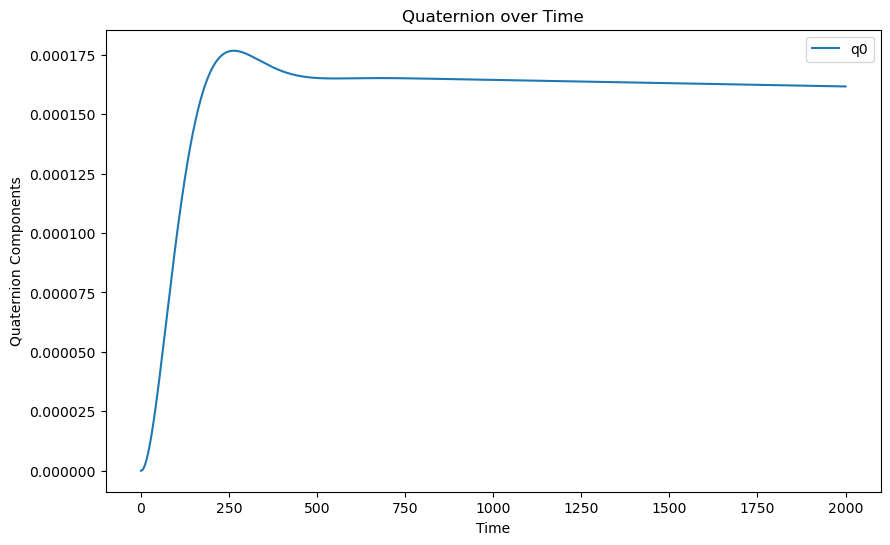

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def quaternion_product(q, p):
    w0, x0, y0, z0 = q
    w1, x1, y1, z1 = p
    return np.array([
        w0*w1 - x0*x1 - y0*y1 - z0*z1,
        w0*x1 + x0*w1 + y0*z1 - z0*y1,
        w0*y1 - x0*z1 + y0*w1 + z0*x1,
        w0*z1 + x0*y1 - y0*x1 + z0*w1
    ])

def quaternion_conjugate(q):
    return np.array([q[0], -q[1], -q[2], -q[3]])

def quaternion_error(q, q_target):
    return quaternion_product(quaternion_conjugate(q), q_target)


def pid_control(q, omega, q_target, integral_error, prev_error, dt):
    error = 2*quaternion_error(q, q_target)[1:]  # Vector part of the quaternion error
    
    integral_error += error * dt
    derivative_error = (error - prev_error) / dt
    
    control_torque = Kp * error + Ki * integral_error + Kd * derivative_error

    return control_torque, integral_error, error,

def dynamics(t, state, integral_error, prev_error, dt):
    q = state[:4]
    omega = state[4:]

    q = q / np.linalg.norm(q)  # Normalize quaternion

    dqdt = 0.5 * quaternion_product(q, np.append([0], omega))
    
    control_torque, integral_error, prev_error = pid_control(q, omega, q_target, integral_error, prev_error, dt)
    
    External_torque = np.array([0.0001, 0.0, 0.0]) # 10e-4 Nm

    Total_torque = control_torque + External_torque

    omega_cross_I_omega = np.cross(omega, I @ omega)
    dwdt = inv_I @ (Total_torque - omega_cross_I_omega)

    return np.concatenate([dqdt, dwdt]), integral_error, prev_error


# RK4 integration method
def rk4_step(dynamics_func, t, state, dt, integral_error, prev_error):
    k1, integral_error1, prev_error1 = dynamics_func(t, state, integral_error, prev_error, dt)
    k2, integral_error2, prev_error2 = dynamics_func(t + 0.5 * dt, state + 0.5 * dt * k1, integral_error1, prev_error1, dt)
    k3, integral_error3, prev_error3 = dynamics_func(t + 0.5 * dt, state + 0.5 * dt * k2, integral_error2, prev_error2, dt)
    k4, integral_error4, prev_error4 = dynamics_func(t + dt, state + dt * k3, integral_error3, prev_error3, dt)

    new_state = state + (dt / 6) * (k1 + 2 * k2 + 2 * k3 + k4)
    return new_state, integral_error4, prev_error4

# Initialize simulation
Ix, Iy, Iz = 1191, 1844, 1798
I = np.diag([Ix, Iy, Iz])  # Inertia matrix
inv_I = np.linalg.inv(I)

# PID controller gains manually tuned
# PID controller gains
Kp = np.array([0.3, 0.3, 0.3])
Ki = np.array([0.000001, 0.000001, 0.000001])
Kd = np.array([100.0, 100.0, 100.0])


# Target quaternion (example target)
#q_target = np.array([0.9938, 0.086, 0.0513, 0.0608])
q_target = np.array([1,0,0,0])
q_target = q_target / np.linalg.norm(q_target) 

q0 = np.array([1, 0, 0, 0])  # Initial quaternion
q0 = q0 / np.linalg.norm(q0)  # Normalize quaternion
omega0 = np.array([0, 0, 0])
state0 = np.concatenate([q0, omega0])

# Simulation parameters
t_span = (0, 2000)  # Time span for the simulation
t_eval = np.linspace(*t_span, 2000)  # Time points where the solution is computed
dt = 1

# Initialize PID errors
integral_error = np.zeros(3)
prev_error = np.zeros(3)
# Initialize storage for control torques
control_torques_history = [(0, 0, 0)]
time_history = [0]
# Run simulation using RK4
states = [state0]
t_values = [t_span[0]]

for t in t_eval[:-1]:
    new_state, integral_error, prev_error = rk4_step(dynamics, t, states[-1], dt, integral_error, prev_error)
    states.append(new_state)
    t_values.append(t + dt)
    control_torque_t, _, _ = pid_control(new_state[:4], new_state[4:], q_target, integral_error, prev_error, dt)
    # Store the control torque and time history
    control_torques_history.append(control_torque_t)
    time_history.append(t)
    #updater for sim
    print(f"Simulation step {t+1}/{len(t_eval)}")

states = np.array(states)
#time in seconds 5000s
time_sec = np.linspace(0, 2000, 2000)
# Output the final state for inspection
print(states[-1])

# Optional: Plot results
plt.figure(figsize=(10, 6))
#plt.plot(time_sec, states[:, :4])
#plotting only q1
plt.plot(time_sec, states[:, 1])
# Put in flat lines of the q target
#plt.plot(time_sec, np.tile(q_target, (len(time_sec), 1)), '--')
plt.xlabel('Time')
plt.ylabel('Quaternion Components')
plt.title('Quaternion over Time')
plt.legend(['q0', 'q1', 'q2', 'q3'])
plt.show()


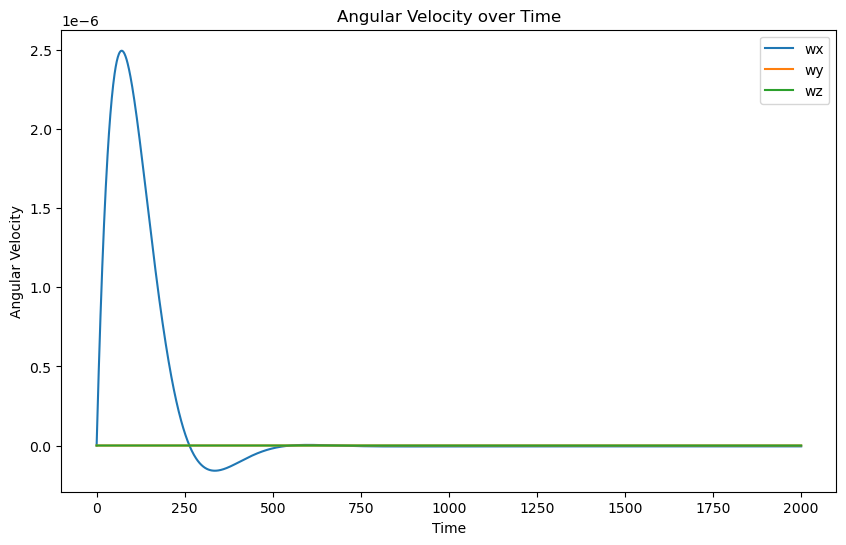

In [4]:
#plot angular velocity
plt.figure(figsize=(10, 6))
plt.plot(time_sec, states[:, 4:])
plt.xlabel('Time')
plt.ylabel('Angular Velocity')
plt.title('Angular Velocity over Time')
plt.legend(['wx', 'wy', 'wz'])
plt.show()

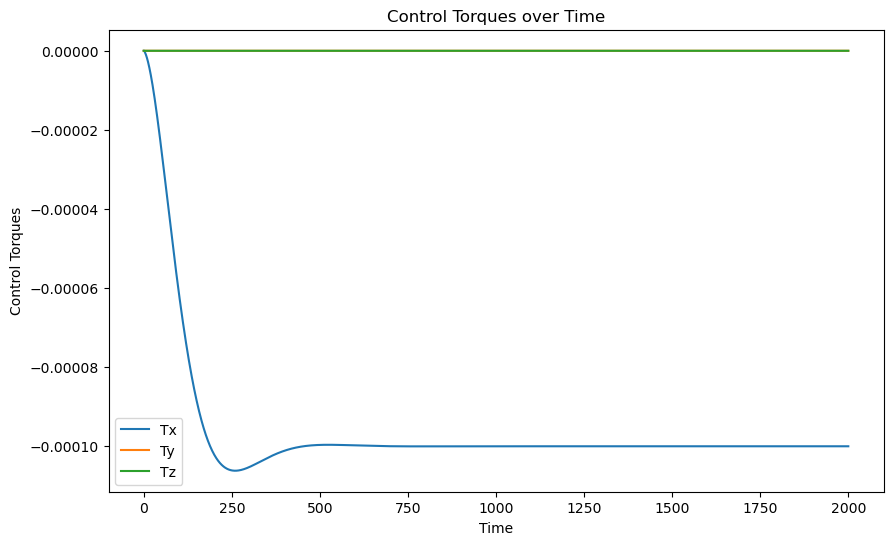

In [5]:
#plot control torques
plt.figure(figsize=(10, 6))
time_sec_control = np.linspace(0, 2000, 2000)
plt.plot(time_sec_control, control_torques_history)
plt.xlabel('Time')
plt.ylabel('Control Torques')
plt.title('Control Torques over Time')
plt.legend(['Tx', 'Ty', 'Tz'])
plt.show()

In [65]:
# save to csv
import pandas as pd
from datetime import datetime

control_torques_history = np.array(control_torques_history)
# Exporting the data into a csv file
def save_simulation_to_csv(filename):
    data = {
        'time': time_history,
        'q0': states[:, 0],
        'q1': states[:, 1],
        'q2': states[:, 2],
        'q3': states[:, 3],
        'omega_x': states[:, 4],
        'omega_y': states[:, 5],
        'omega_z': states[:, 6],
        'Total_torque_x': control_torques_history[:, 0],
        'Total_torque_y': control_torques_history[:, 1],
        'Total_torque_z': control_torques_history[:, 2],
    }
    df = pd.DataFrame(data)
    df.to_csv(filename, index=False)

date_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
file_name = f"satellite_attitude_control_PID_RK4_Tuned_External_torques_10e-4Nm_NoManuever_{date_time}.csv"
save_simulation_to_csv(file_name)

The system stabilizes at time step: 99.0495247623812 seconds


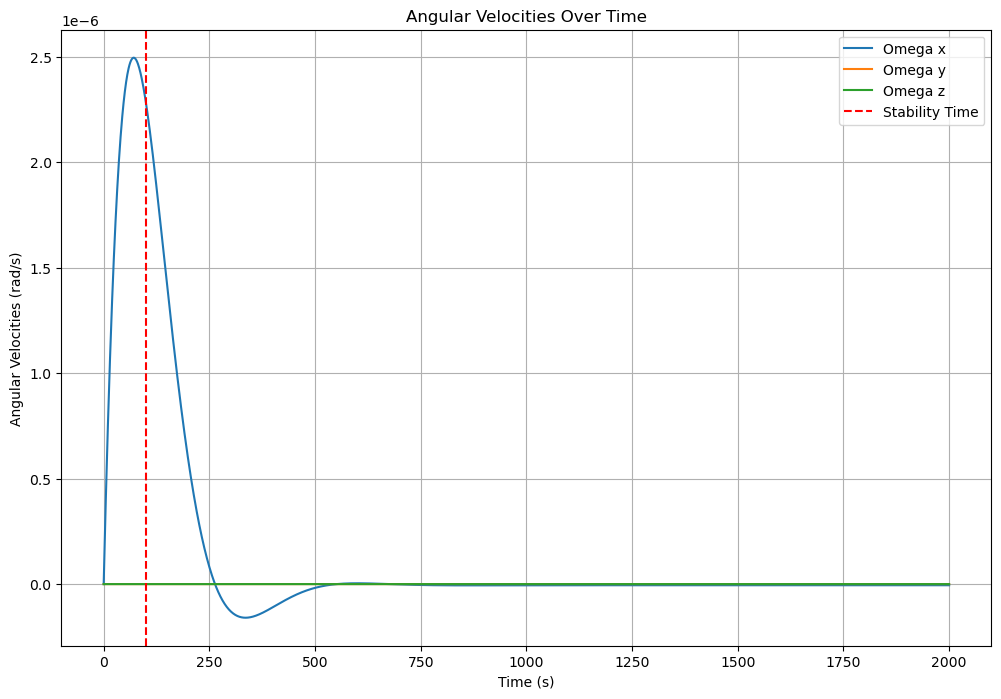

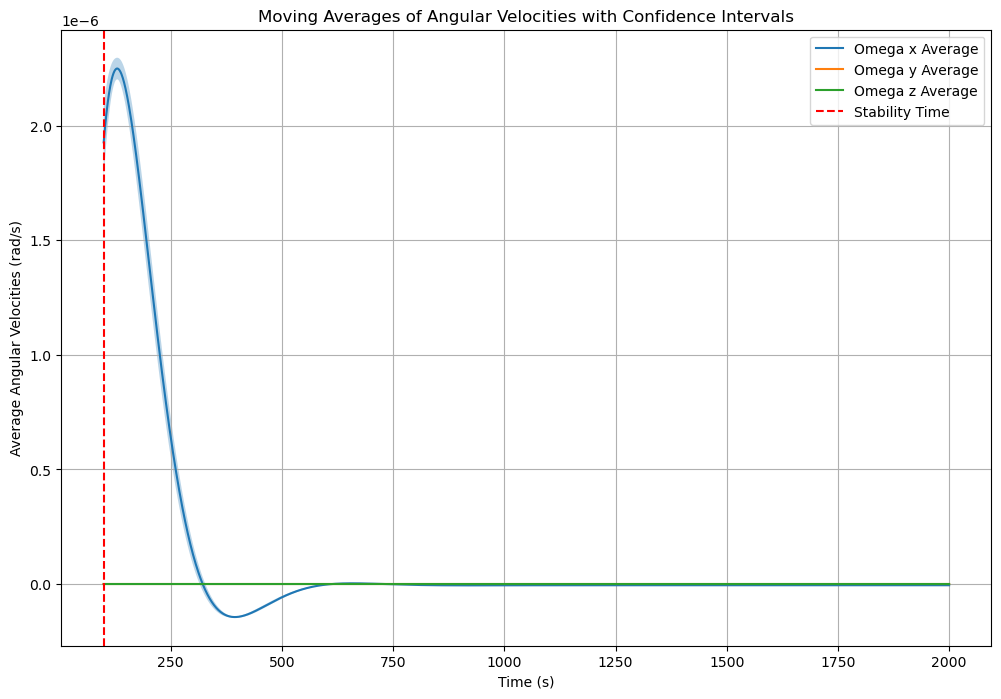

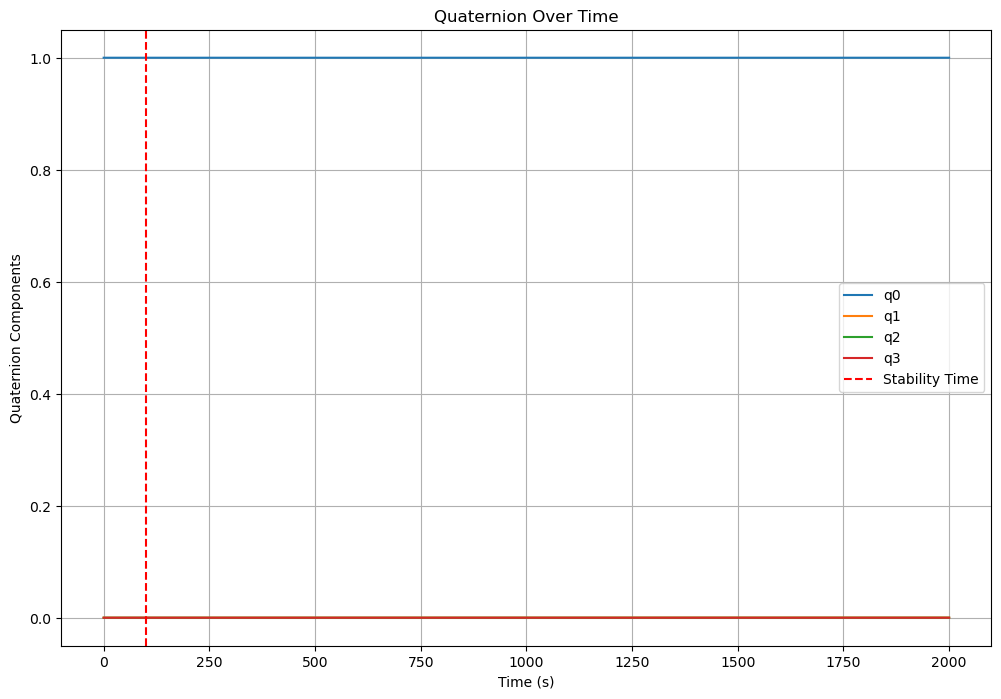

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import sem, t

# Assume `states` and `control_torques` are available from the simulation
# `states` contains quaternions and angular velocities
# `control_torques` contains the control torques for each timestep

# Extract angular velocities and time from simulation data
omega = states[:, 4:]  # Extract angular velocity components
time_sec = np.linspace(0, 2000, 2000)  # Time array matching simulation

# Parameters
threshold = 1e-5
window_size = 100
confidence = 0.97

# Calculate moving averages
omega_avg = np.array([
    np.convolve(omega[:, i], np.ones(window_size) / window_size, mode='valid')
    for i in range(3)
]).T

# Calculate standard errors of the mean (SEM)
omega_sem = np.array([
    np.array([sem(omega[j:j + window_size, i]) for j in range(len(omega) - window_size + 1)])
    for i in range(3)
]).T

# Calculate confidence intervals
degrees_freedom = window_size - 1
confidence_factor = t.ppf((1 + confidence) / 2., degrees_freedom)

omega_ci = omega_sem * confidence_factor

# Check when values are within threshold
def check_stability_with_ci(omega_avg, omega_ci, threshold, window_size):
    for i in range(len(omega_avg)):
        if (np.all(np.abs(omega_avg[i]) < threshold) and
            np.all(omega_ci[i] < threshold)):
            return time_sec[i + window_size - 1], i + window_size - 1
    return -1, -1

stable_time_step, stable_index = check_stability_with_ci(omega_avg, omega_ci, threshold, window_size)

print(f"The system stabilizes at time step: {stable_time_step} seconds")

# Plot angular velocities over time with a marker for stability time
plt.figure(figsize=(12, 8))
plt.plot(time_sec, omega[:, 0], label='Omega x')
plt.plot(time_sec, omega[:, 1], label='Omega y')
plt.plot(time_sec, omega[:, 2], label='Omega z')
if stable_time_step != -1:
    plt.axvline(x=stable_time_step, color='r', linestyle='--', label='Stability Time')
plt.xlabel('Time (s)')
plt.ylabel('Angular Velocities (rad/s)')
plt.title('Angular Velocities Over Time')
plt.legend()
plt.grid(True)
plt.show()

# Plot moving averages with confidence intervals
plt.figure(figsize=(12, 8))
plt.plot(time_sec[window_size - 1:], omega_avg[:, 0], label='Omega x Average')
plt.fill_between(time_sec[window_size - 1:], omega_avg[:, 0] - omega_ci[:, 0], omega_avg[:, 0] + omega_ci[:, 0], alpha=0.3)
plt.plot(time_sec[window_size - 1:], omega_avg[:, 1], label='Omega y Average')
plt.fill_between(time_sec[window_size - 1:], omega_avg[:, 1] - omega_ci[:, 1], omega_avg[:, 1] + omega_ci[:, 1], alpha=0.3)
plt.plot(time_sec[window_size - 1:], omega_avg[:, 2], label='Omega z Average')
plt.fill_between(time_sec[window_size - 1:], omega_avg[:, 2] - omega_ci[:, 2], omega_avg[:, 2] + omega_ci[:, 2], alpha=0.3)
if stable_time_step != -1:
    plt.axvline(x=stable_time_step, color='r', linestyle='--', label='Stability Time')
plt.xlabel('Time (s)')
plt.ylabel('Average Angular Velocities (rad/s)')
plt.title('Moving Averages of Angular Velocities with Confidence Intervals')
plt.legend()
plt.grid(True)
plt.show()

# Plot quaternion components over time with stability time
plt.figure(figsize=(12, 8))
plt.plot(time_sec, states[:, 0], label='q0')
plt.plot(time_sec, states[:, 1], label='q1')
plt.plot(time_sec, states[:, 2], label='q2')
plt.plot(time_sec, states[:, 3], label='q3')
if stable_time_step != -1:
    plt.axvline(x=stable_time_step, color='r', linestyle='--', label='Stability Time')
plt.xlabel('Time (s)')
plt.ylabel('Quaternion Components')
plt.title('Quaternion Over Time')
plt.legend()
plt.grid(True)
plt.show()